**Implementation of the Multiple Linear Regression Algorithm**

Model Set-Up

> This is to set up the model by importing relevant packages/libraries and reading in the data




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/ZelongCAI/31005_Assessment2/main/bmw.csv'
car_price = pd.read_csv(url)

Data Understanding


> Understand the dataset as a whole 



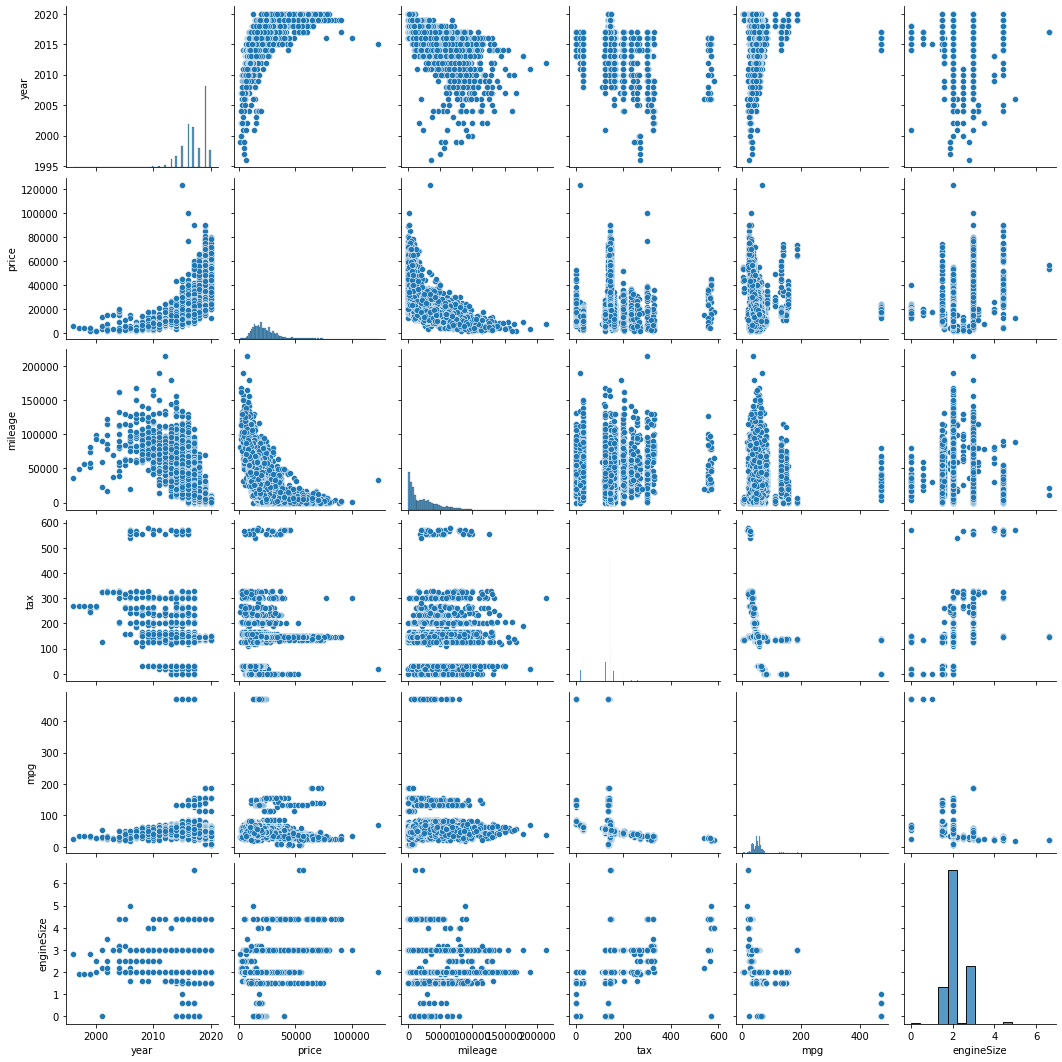

In [ ]:
#view the first 5 rows in the dataset
car_price.head()
#Check for missing values
car_price.isna().sum()
#describe and find shape of the data
car_price.describe()
car_price.shape
#create a correlation matrix that shows the correlation between all numerical attributes
corr=car_price.corr()
corr.style.background_gradient(cmap="RdYlGn")
#Create graphs for the numerical data
sns.pairplot(car_price)

Data Preprocessing
> Preprocess and clean the data before using the data in the model


,price,mileage,mpg,engineSize,car_age,mileage_age,fuelType_Hybrid
price,1.000000,-0.675442,-0.415326,0.378185,-0.722588,-0.726206,0.068667
mileage,-0.675442,1.000000,0.208074,0.115181,0.765909,0.782501,-0.060134
mpg,-0.415326,0.208074,1.000000,-0.421012,0.057662,0.059336,-0.107427
engineSize,0.378185,0.115181,-0.421012,1.000000,0.125521,0.127509,-0.019375
car_age,-0.722588,0.765909,0.057662,0.125521,1.000000,0.997207,-0.055082
mileage_age,-0.726206,0.782501,0.059336,0.127509,0.997207,1.000000,-0.051434
fuelType_Hybrid,0.068667,-0.060134,-0.107427,-0.019375,-0.055082,-0.051434,1.000000


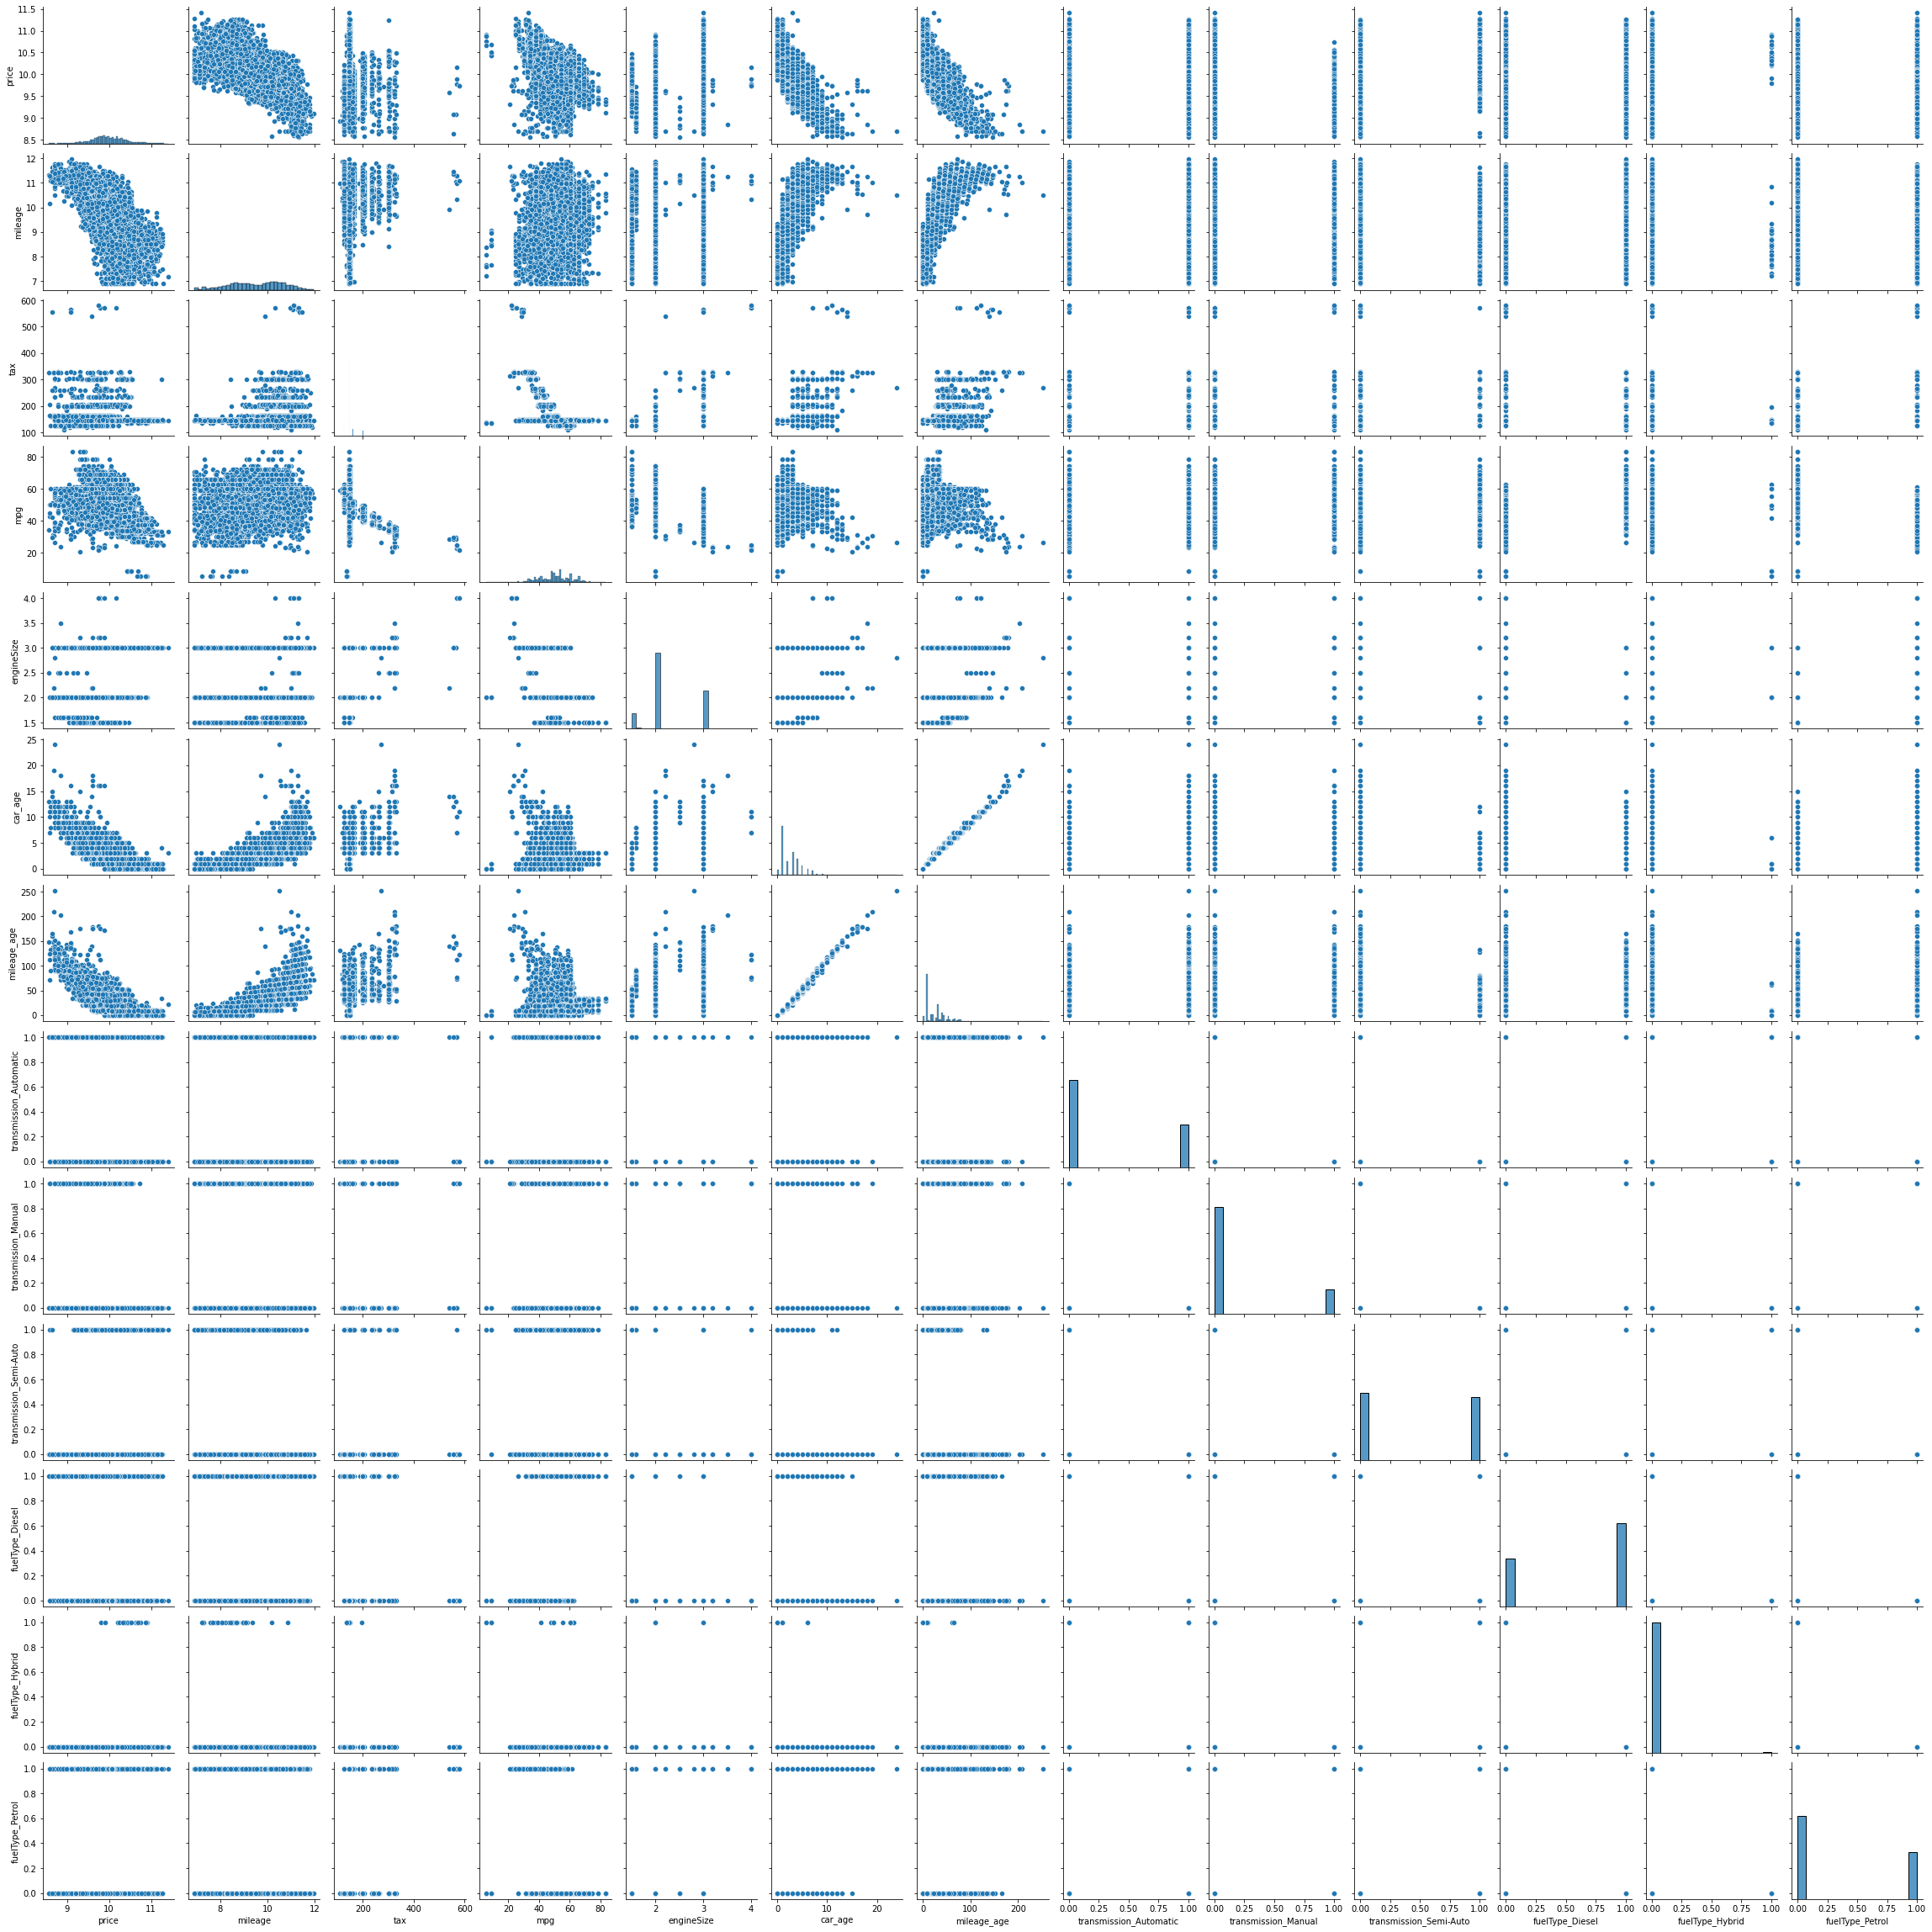

In [ ]:
#drop the columns that does will not be helpful based on correlation matrix and understanding of attributes
car_price['car_age']= 2020-car_price['year']
car_price = car_price.drop(['model','year'],axis=1)

#Remove Outliers
car_price.drop(index=car_price[car_price["mileage"]>160000].index,inplace=True)
car_price.drop(index=car_price[car_price["mileage"]<1000].index,inplace=True)
car_price.drop(index=car_price[car_price["engineSize"]==0].index,inplace=True)
car_price.drop(index=car_price[car_price["price"]<5000].index,inplace=True)
car_price.drop(index=car_price[car_price["tax"]<100].index,inplace=True)
car_price.drop(index=car_price[car_price["mpg"]>85].index,inplace=True)
car_price.drop(index=car_price[car_price["engineSize"]>4].index,inplace=True)

#Data Transformation and Creation of New Variables
car_price['price']=np.log(car_price['price'])
car_price['mileage']=np.log(car_price['mileage'])
car_price['mileage_age']= car_price['mileage'] * car_price['car_age']

#get a list of all columns that are numerical and categorical
num_col = car_price.select_dtypes(exclude=['object']).columns
cat_col = car_price.select_dtypes(include=['object']).columns

#transform categorical variables into dummy variables
dummy_var = pd.get_dummies(car_price[cat_col])
dummy_var.shape
dummy_var.head()

#add new variables to the original dataset
car_price = pd.concat([car_price[num_col], dummy_var], axis=1)
car_price.head()

#Create graphs for the transformed data
sns.pairplot(car_price)

#create a correlation matrix that shows the correlation between all numerical attributes and the transformed categorical variables
corr=car_price.corr()
corr.style.background_gradient(cmap="RdYlGn")

#Remove variables that have a correlation in the range of -0.45 to 0.45
car_price_v1 = car_price.drop(['tax','transmission_Manual','transmission_Automatic','transmission_Semi-Auto','fuelType_Diesel','fuelType_Petrol'],axis=1)

#Re-run correlation matrix with the variables
corr=car_price_v1.corr()
corr.style.background_gradient(cmap="RdYlGn")

Algorithm Implementation

> Finish setting up the dataset





In [ ]:
#Dataset Set Up
Y_df = car_price_v1['price']
X_df = car_price_v1.drop(['price'],axis=1)

Y = Y_df.values
X = X_df.values

#Split Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6202, 6) (1551, 6) (6202,) (1551,)


> Class to implement the key aspects of the Ordinary Least Squares procedure



In [ ]:
#create a class for the beta coefficients of the model and make predictions using the Ordinary Least Squares procedure
class OrdinaryLeastSquares(object):

# Create empty array
  def __init__(self):
    self.coefficients = []
    self.y_predictions = []
    self.standard_error = []
    self.residuals_y = []
    self.t_test = []
    self.model_table = []
    
# Matrix Calculation for the Beta Coefficients - B = (X' * X)^-1 * X' * Y  
  def fit(self, X, y):
    X = self.add_ones(X)
    self.coefficients = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

#Add a new column of ones to the first column in Matrix X
  def add_ones(self, X):
    ones = np.ones(shape=X.shape[0]).reshape(-1,1)
    return np.concatenate((ones, X), 1)

#Using the predicted coefficients, append the predictions into an array
  def predict_y(self, X):
    for row in X: self.y_predictions.append(self.predict(row))

#Create the regression equation to predict the value of price for each row
  def predict(self, entry):
    b0 = self.coefficients[0]
    prediction_betas = self.coefficients[1:]
    predictions = b0

    for x_i, b_i in zip(entry, prediction_betas): predictions += (b_i * x_i)
    return predictions

#Standard Error Calculation 
  def std_error(self, X, Y):
    num_obs = len(X)
    num_col = len(X[0])
    deg_free = num_obs - num_col -1

    p_1 = np.asarray(self.residuals(Y, self.y_predictions)/deg_free)
    X = self.add_ones(X)

    s_e = np.dot(p_1,self.std_e_matrix(X))
    self.standard_error = np.diagonal(s_e)
  
# Matrix Calculation for the Standard Error - X = (X' * X)^-1 
  def std_e_matrix(self, X):
    matrix_x = np.linalg.inv(X.transpose().dot(X))
    return matrix_x

#Sum of Y Residuals   
  def residuals(self, y, y_predictions):
    y_resid = (y-self.y_predictions)**2
    y_sum = np.sum(y_resid)
    return y_sum

#T-Test
  def t_test_table (self):
    std_error = self.standard_error.transpose()
    beta_c = self.coefficients.transpose()

    data_t = [beta_c,std_error]

    new_df = pd.DataFrame(data=data_t)
    self.t_test= new_df.transpose()
    self.t_test = self.t_test.rename(columns={0:"Coefficient",1:"Stnd Error"})
    self.t_test["t_value"] = self.t_test["Coefficient"]/self.t_test["Stnd Error"]

# Observed and Predictions Table
  def final_model_table (self, y_values):
    y_predictions = np.array(self.y_predictions)
    table = [y_values, y_predictions]
    table = pd.DataFrame(data=table)
    self.model_table = table.transpose()
    self.model_table = self.model_table.rename(columns={0:"Observed",1:"Predicted"})

model = OrdinaryLeastSquares()
model.fit(X_train,y_train)
model.predict_y(X_train)
model.std_error(X_train,y_train)
model.t_test_table()

y1 = model.y_predictions
x1 = model.coefficients
model.t_test

,Coefficient,Stnd Error,t_value
0,10.745300,1.238525e-03,8675.881770
1,-0.090417,1.440977e-05,-6274.686540
2,-0.006666,7.564230e-08,-88120.288080
3,0.327358,2.589786e-05,12640.330859
4,-0.045138,2.314361e-04,-195.034918
5,-0.006083,1.976236e-06,-3078.260697
6,0.097035,1.294713e-03,74.946849




> Evaluate the Final Model 




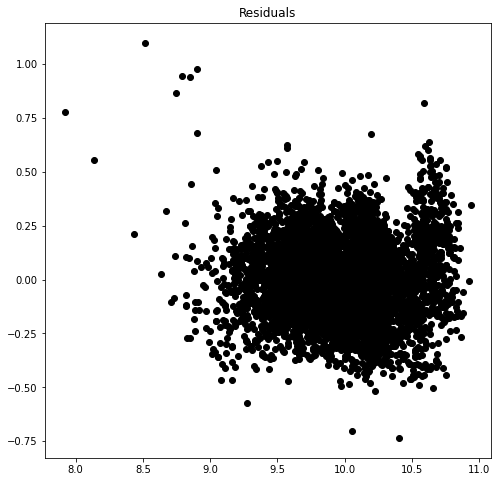

<Figure size 576x576 with 0 Axes>

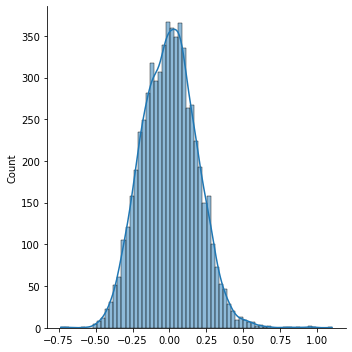

In [ ]:
#create a class to evaluate the final model
class Evaluation(object):

#RMSE
  def RMSE(self, y, y_predictions):
    y_resid = (y_predictions-y)**2
    y_sum = np.sum(y_resid)
    RMSE = np.sqrt(y_sum/len(y))
    return RMSE

#R-Sq
  def R_Square(self, y, y_predictions):
    y_resid = (y-y_predictions)**2
    y_sum_a = np.sum(y_resid)

    SST= (y- np.mean(y))**2
    y_sum_b = np.sum(SST)
    R_Sq = 1-(y_sum_a/y_sum_b)
    return R_Sq

#R-Sq Adj
  def R_Sq_Adj(self, X, y, y_predictions):
    n = len(y)
    m = len(X[0])

    R_Sq_Adj = 1 - ((1-self.R_Square(y, y_predictions))*n-1)/(n-m-1)
    return R_Sq_Adj

#Create a predicted value residual plot
  def pred_value_plot (self, y, pred_y):
    y_resid = y-pred_y
    plt.figure(figsize=(8,8))
    plt.title('Residuals')
    return plt.plot(pred_y, y_resid, 'o',color='black')

#Create a normality histogram
  def normality_histogram (self, y, pred_y):
    residuals = y-pred_y
    plt.figure(figsize=(8,8))
    return sns.displot(residuals, kde=True)

model_E = Evaluation()
model_E.RMSE(y_train,y1)
model_E.R_Sq_Adj(X_train, y_train,y1)
model_E.R_Square( y_train,y1)
model_E.pred_value_plot(y_train,y1)
model_E.normality_histogram(y_train,y1)



> Run Regression using the Test Data and Evaluate the Model



The RMSE value is 0.1846866341270058
The R2 Adjusted value is 0.808644722327149


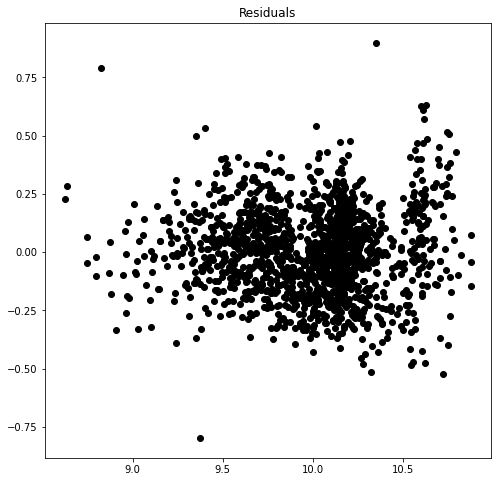

<Figure size 576x576 with 0 Axes>

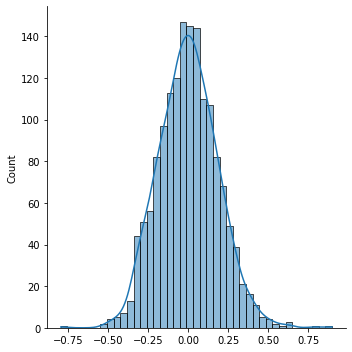

In [ ]:
#Run OLS Model
model_main = OrdinaryLeastSquares()
model_main.fit(X_test,y_test)
model_main.predict_y(X_test)
model_main.std_error(X_test,y_test)
model_main.t_test_table()
model_main.final_model_table(y_test)
model_main.t_test
model_main.model_table

y1 = model_main.y_predictions

#Run Evaluation
model_Evaluation = Evaluation()
print("The RMSE value is " + str(model_Evaluation.RMSE(y_test,y1)))
print("The R2 Adjusted value is " + str(model_Evaluation.R_Sq_Adj(X_test, y_test,y1)))
model_Evaluation.R_Square(y_test,y1)
model_Evaluation.pred_value_plot(y_test,y1)
model_Evaluation.normality_histogram(y_test,y1)